In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
from torchvision import transforms

import h5py

from tqdm import tqdm

In [2]:
device = torch.device('cuda')

## Data

In [3]:
torch.use_deterministic_algorithms(True)

import os

# Variable must be set to allow deterministic
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

torch_rng = torch.manual_seed(777)
np_rng = np.random.default_rng(777)

np.random.seed(777)

In [4]:
# Non bitsliced
#train_hdf = h5py.File("C:/Data/simpleserial-aes-500000-diff-profile.hdf5")
#val_test_hdf = h5py.File("C:/Data/simpleserial-aes-500-diff.hdf5")

In [5]:
train_hdf = h5py.File("C:/Data/simpleserial-aes-fix-500000-diff-profile.hdf5")

In [6]:
val_test_hdf = h5py.File("C:/Data/simpleserial-aes-fix-500-diff.hdf5")

In [7]:
train_traces = torch.Tensor(np.array(train_hdf['trace']))
train_plaintexts = torch.Tensor(np.array(train_hdf['data']))
train_keys = torch.Tensor(np.array(train_hdf['key']))

In [8]:
val_test_traces = torch.Tensor(np.array(val_test_hdf['trace']))
val_test_plaintexts = torch.Tensor(np.array(val_test_hdf['data']))
val_test_keys = torch.Tensor(np.array(val_test_hdf['key']))

In [9]:
print(f"Train traces shape: {train_traces.shape}")
print(f"Train keys shape: {train_keys.shape}")
print(f"Train plaintexts shape: {train_plaintexts.shape}")

print(f"Test traces shape: {val_test_traces.shape}")
print(f"Test keys shape: {val_test_keys.shape}")
print(f"Test plaintexts shape: {val_test_plaintexts.shape}")

Train traces shape: torch.Size([500000, 5000])
Train keys shape: torch.Size([500000, 16])
Train plaintexts shape: torch.Size([500000, 32])
Test traces shape: torch.Size([1000, 500, 5000])
Test keys shape: torch.Size([1000, 16])
Test plaintexts shape: torch.Size([1000, 500, 32])


### Computing S-box output

In [10]:
s_box = [
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16,
]

inverted_s_box = [0] * 256

for idx, bytevalue in enumerate(s_box):
    inverted_s_box[bytevalue] = idx

In [11]:
train_sbox_output = torch.empty((500000,16))
val_test_sbox_output = torch.empty((1000,500,16))

for idx, (key, plaintext) in enumerate(zip(train_keys, train_plaintexts)):

    block = plaintext.clone()[:16]

    block.map_(key, lambda x,y: s_box[int(x) ^ int(y)])

    block = block.long()

    train_sbox_output[idx] = block

for key_idx in range(val_test_traces.shape[0]):
    for idx, (key, plaintext) in enumerate(zip(val_test_keys[key_idx], val_test_plaintexts[key_idx])):

        block = plaintext.clone()[:16]

        block.map_(key, lambda x,y: s_box[int(x) ^ int(y)])

        block = block.long()

        val_test_sbox_output[key_idx, idx] = block

In [12]:
print(train_sbox_output.shape)
print(val_test_sbox_output.shape)

torch.Size([500000, 16])
torch.Size([1000, 500, 16])


### Sample

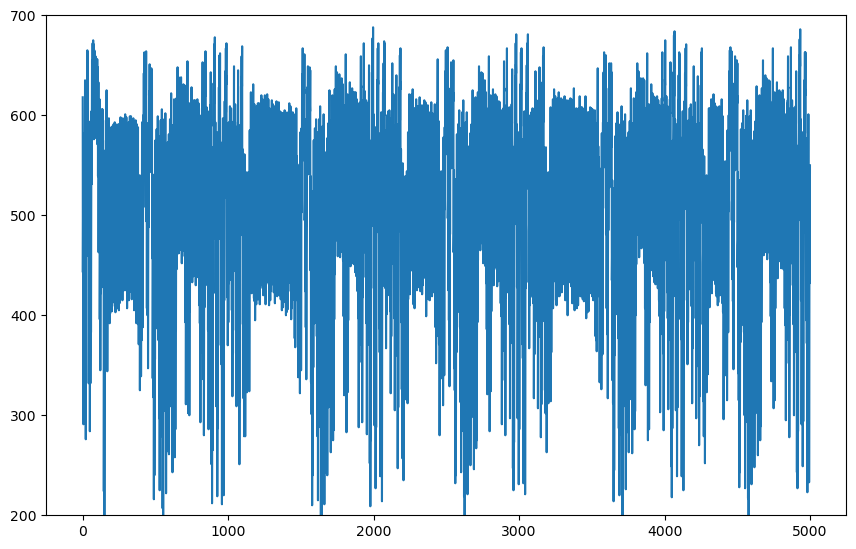

In [13]:
fig = plt.figure(1,(8.0, 5.0))

ax = fig.add_axes((1.0, 1.0, 1.0, 1.0))
ax.set_ylim(200.0, 700.0)

ax.plot(np.arange(5000), train_traces[99000])

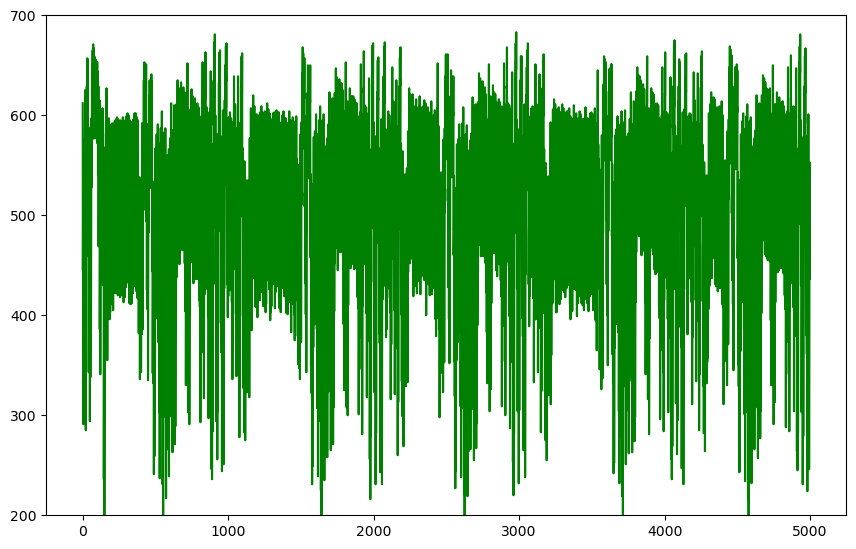

In [14]:
fig = plt.figure(1,(8.0, 5.0))
ax = fig.add_axes((1.0, 1.0, 1.0, 1.0))
ax.set_ylim(200.0, 700.0)

ax.plot(np.arange(5000), val_test_traces[450,4], color='green')

In [19]:
TRACE_INTERVAL_START = 0
TRACE_INTERVAL_END = 1000

train_traces_trunc = train_traces[..., TRACE_INTERVAL_START:TRACE_INTERVAL_END]
val_test_traces_trunc = val_test_traces[..., TRACE_INTERVAL_START:TRACE_INTERVAL_END]
train_traces_trunc = train_traces
val_test_traces_trunc = val_test_traces

print(train_traces_trunc.shape)
print(val_test_traces_trunc.shape)

torch.Size([500000, 5000])
torch.Size([1000, 500, 5000])


In [20]:
train_traces_mean = train_traces_trunc.mean()
train_traces_std = train_traces_trunc.std()

In [21]:
train_traces_norm = (train_traces_trunc - train_traces_mean) / train_traces_std
val_test_traces_norm = (val_test_traces_trunc - train_traces_mean) / train_traces_std

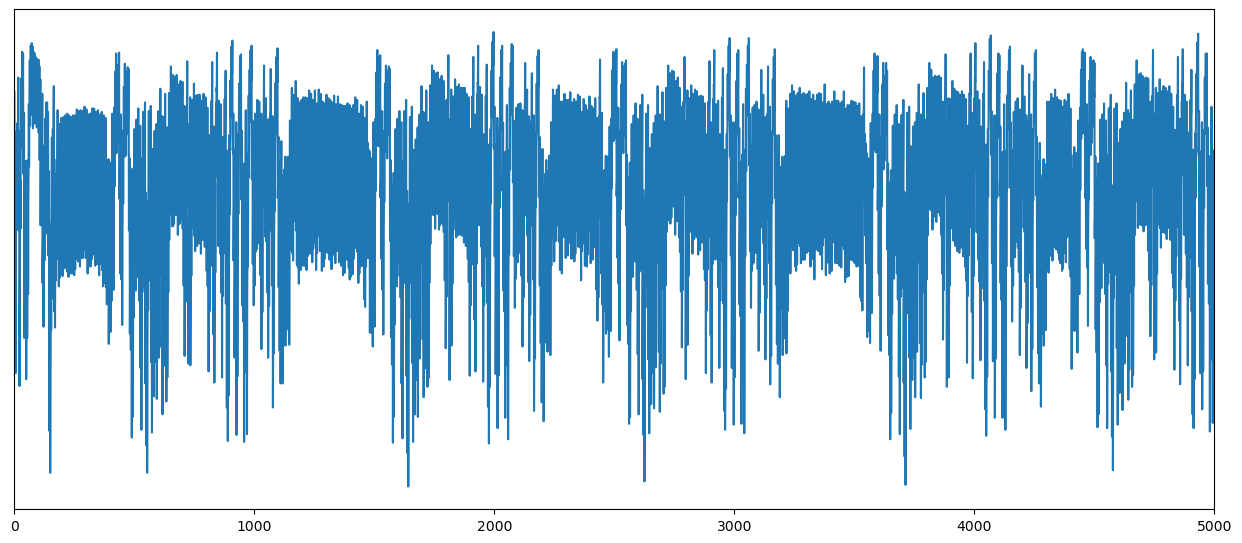

: 

In [ ]:
# Large trace illustration for thesis chapter
fig = plt.figure(1,(12.0, 5.0))

ax = fig.add_axes((1.0, 1.0, 1.0, 1.0))
ax.set_xlim(0.0, 5000.0)
ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax.plot(np.arange(5000), train_traces_norm[99000])

## Dataset

In [18]:
class TrainingTraceSet(Dataset):
    def __init__(self, traces : torch.Tensor, keys, subkey_idx):

        self.traces = traces
        self.keys = keys[..., subkey_idx]

    def __len__(self):
        return self.traces.shape[0]
    
    def __getitem__(self, idx) -> tuple[torch.Tensor, torch.Tensor]:
        sample = self.traces[idx]
        target = self.keys[idx]
        return (sample, target)

In [19]:
class TestingTraceSet(Dataset):
    def __init__(self, traces, keys, subkey_idx):

        self.traces = traces
        self.keys = keys[..., subkey_idx]

    def __len__(self):
        return self.traces.shape[0]
    
    def __getitem__(self, idx):
        # One sample, N traces
        traces = self.traces[idx]
        key = self.keys[..., idx]

        return (traces, key)

In [20]:
class SboxTestingTraceSet(Dataset):
    def __init__(self, traces, plaintexts, keys, subbyte_idx):

        self.traces = traces

        # Plaintext must be included to map possible sbox outpouts back to keys
        self.plaintexts = plaintexts[..., subbyte_idx]
        self.keys = keys[..., subbyte_idx].squeeze()

    def __len__(self):
        return self.traces.shape[0]
    
    def __getitem__(self, idx):
        # One sample, N traces, N plaintexts, single key
        traces = self.traces[idx]
        plaintexts = self.plaintexts[idx].squeeze()
        key = self.keys[idx]

        return (traces, plaintexts, key)

## Model

In [21]:
# Zhang2019
class CNN_ZHANG(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.network : nn.Sequential = nn.Sequential(
            
            nn.Conv1d(1, 64, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Conv1d(64, 128, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Conv1d(128, 256, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Conv1d(256, 512, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Conv1d(512, 512, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Flatten(),

            #nn.Linear(18944, 4096), # 1500
            nn.Linear(10752, 4096), # 1000
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 256),
            # Cross entropy expects raw logits
            # https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
        )

    def forward(self, x):

        # Add channel dimension for conv
        x = x.unsqueeze(1)

        output = self.network(x)

        return output


In [22]:
# different name matching older .pt files
class SCACNN(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.network : nn.Sequential = nn.Sequential(
            
            nn.Conv1d(1, 64, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Conv1d(64, 128, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Conv1d(128, 256, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Conv1d(256, 512, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Conv1d(512, 512, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Flatten(),

            nn.Linear(10752, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 256),
            # Cross entropy expects raw logits
            # https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
        )

    def forward(self, x):

        # Add channel dimension for conv
        x = x.unsqueeze(1)

        output = self.network(x)

        return output


In [23]:
class CNN_Hettwer(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.network : nn.Sequential = nn.Sequential(
            
            nn.Conv1d(1, 8, 8),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            nn.Dropout(0.3),

            nn.Conv1d(8, 16, 8),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            nn.Dropout(0.3),

            nn.Conv1d(16, 32, 8),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            nn.Dropout(0.3),

            nn.Conv1d(32, 64, 8),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            nn.Dropout(0.3),

            nn.Flatten(),

            nn.Linear(3520, 20),
            nn.ReLU(),
            nn.Linear(20, 256),
            # Cross entropy expects raw logits
            # https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
        )

    def forward(self, x):

        # Add channel dimension for conv
        x = x.unsqueeze(1)

        output = self.network(x)

        return output

## Computing keyrank

In [24]:
from importlib import reload
import keyrank_rs

# Changes to external module don't come into effect before reloading or restarting kernel
keyrank_rs = reload(keyrank_rs)

In [25]:
def mean_keyrank2(model : nn.Module, test_loader : DataLoader):
    total_rank = 0
    
    for traces, key in tqdm(test_loader, 'computing keyrank'):

        traces = traces.to(device)
        key = key.to(device)

        output = model(traces.squeeze())

        _, rankings = torch.unique(-output, sorted=True, return_inverse=True, dim=-1)

        rankings = rankings.type(torch.float64)

        current_rank = (rankings * F.one_hot(key.long(), 256)).sum()

        # Multiply with one hot tensor to retain only rank of target class
        total_rank += current_rank


    mean_rank = total_rank / len(test_loader)

    return mean_rank


In [26]:
def mean_keyrank(model : nn.Module, test_loader : DataLoader):
    total_rank = 0

    for traces, key in tqdm(test_loader, 'computing keyrank', leave=False):

        traces = traces.to(device)
        key = key.to(device)

        output : torch.Tensor = model(traces.squeeze())

        output = output.softmax(dim=0).log().sum(dim=0)

        ranks = output.argsort(dim=-1, descending=True).argsort(dim=-1)

        total_rank += ranks[..., int(key)].mean(dtype=float)

    mean_rank = total_rank / len(test_loader)

    return mean_rank

In [ ]:
def mean_sbox_rank(model, sbox_test_loader):
    """Compute mean keyrank from an sbox predicting model across trace set of N keys with M traces per key"""
    total_rank = 0

    for traces, plaintexts, true_key in tqdm(sbox_test_loader, 'computing keyrank', leave=False):

        traces : torch.Tensor = traces.to(device)
        plaintexts : torch.Tensor = plaintexts[..., 0].squeeze().to(device)

        sbox_scores : torch.Tensor = model(traces.squeeze())

        plaintexts = plaintexts.long().detach().cpu().numpy()
        numpy_scores = sbox_scores.detach().cpu().numpy()
            
        numpy_keyscores = keyrank_rs.sbox_scores_to_keyscores_parallel(plaintexts, numpy_scores)

        keyscores = torch.Tensor(numpy_keyscores).to(device)

        # logsum scores before calculating rank
        keyscores = keyscores.softmax(dim=1).log().sum(dim=0)

        ranks = keyscores.argsort(dim=-1, descending=True).argsort(dim=-1)
        
        total_rank += ranks[..., int(true_key)].mean(dtype=float)

    mean_rank = total_rank / len(sbox_test_loader)

    return mean_rank


In [47]:
def mean_sbox_rank_per_trace(model : nn.Module, sbox_test_loader : DataLoader):
    
    total_rank = torch.zeros(500)

    for traces, plaintexts, true_key in tqdm(sbox_test_loader, 'computing keyrank', leave=False):

        traces : torch.Tensor = traces.to(device)
        plaintexts : torch.Tensor = plaintexts.squeeze().to(device)


        sbox_scores : torch.Tensor = model(traces.squeeze())

        keyscores = torch.empty(sbox_scores.shape)


        plaintexts = plaintexts.long().detach().cpu().numpy()
        numpy_scores = sbox_scores.detach().cpu().numpy()
            
        numpy_keyscores : np.array = keyrank_rs.sbox_scores_to_keyscores_parallel(plaintexts, numpy_scores)

        keyscores = torch.Tensor(numpy_keyscores)

        # logsum scores before calculating rank
        keyscores = keyscores.softmax(dim=1).log()
        keyscore_acc = torch.zeros(256)

        for idx,keyscore in enumerate(keyscores):
            keyscore_acc += keyscore

            ranks = keyscore_acc.argsort(descending=True).argsort()
        
            total_rank[idx] += ranks[..., int(true_key)].mean(dtype=float)

    mean_ranks = total_rank / len(sbox_test_loader)

    return mean_ranks

## Training

In [30]:
import os

def train_model(
        model : nn.Module,
        optimizer : optim.Optimizer,
        loss_fn,
        train_loader : DataLoader,
        val_loader : DataLoader,
        folder,
        scores = ([],[]),
        n_epochs = 10,
        prediction_target = "key"
    ):

    model.to(device)

    os.makedirs(f"models/{folder}", exist_ok=True)

    train_losses = scores[0]
    val_ranks = scores[1]

    for epoch in range(n_epochs):

        model.train()

        train_loss = 0

        for input, target in tqdm(train_loader, 'training model', unit='batch', leave=False):

            target = target.type(torch.LongTensor)

            #target_onehot = F.one_hot(target, 256).to(device)



            # Move batch to GPU
            input = input.to(device)
            target = target.to(device)

            optimizer.zero_grad()

            outputs = model(input)

            loss = loss_fn(outputs, target)

            loss.backward()

            optimizer.step()

            train_loss+=loss.item()



        train_loss /= len(train_loader)

        train_losses.append(train_loss / len(train_loader.dataset))


        # Validate
        model.eval()
        with torch.no_grad():
            if prediction_target == "key":
                val_mean_rank = mean_keyrank(model, val_loader)
            else:
                val_mean_rank = mean_sbox_rank(model, val_loader)
            
        val_ranks.append(val_mean_rank)

        torch.save(model, f"models/{folder}/epoch{epoch+1}.pt")
        
        print(f"Epoch #{epoch+1} of {n_epochs}, training loss: {train_loss:.3f}, val mean keyrank: {val_mean_rank:.3f}")

    return (train_losses, val_ranks)

In [29]:
EPOCHS = 100
BATCH_SIZE = 200 #
PREDICTION_TARGET = "sbox"
TARGET_BYTE_IDX = 1
LEARNING_RATE = 0.00001

In [30]:
# Dataset with sbox or key as target
key_train_set = TrainingTraceSet(train_traces_norm[:,:], train_keys, TARGET_BYTE_IDX)
key_val_test_set = TestingTraceSet(val_test_traces_norm, val_test_keys, TARGET_BYTE_IDX)

sbox_train_set = TrainingTraceSet(train_traces_norm[:,:], train_sbox_output, TARGET_BYTE_IDX)
sbox_val_test_set = SboxTestingTraceSet(val_test_traces_norm, val_test_plaintexts, val_test_keys, TARGET_BYTE_IDX)

key_val_set, key_test_set = random_split(key_val_test_set, [0.5, 0.5], generator = torch_rng)
sbox_val_set, sbox_test_set = random_split(sbox_val_test_set, [0.5, 0.5], generator = torch_rng)

key_train_loader = DataLoader(key_train_set, batch_size=BATCH_SIZE, shuffle=True, generator=torch_rng)
key_val_loader = DataLoader(key_val_set)
key_test_loader = DataLoader(key_test_set)

sbox_train_loader = DataLoader(sbox_train_set, batch_size=BATCH_SIZE, shuffle=True, generator=torch_rng)
sbox_val_loader = DataLoader(sbox_val_set)
sbox_test_loader = DataLoader(sbox_test_set)

In [33]:
from importlib import reload
import transnet
transnet = reload(transnet)


torch.manual_seed(777)
model = CNN_ZHANG().to(device)

In [31]:
# Zhang 2019
adam = optim.Adam(model.parameters(), lr=0.00001)
#sgd = optim.SGD(model.parameters(), lr=0.00001)

# Hettwer 2020, optimizer not specified
#adam = optim.Adam(model.parameters(), lr=0.001)

cross_entropy = nn.CrossEntropyLoss()

optimizer = adam

hyperparameters = {
    "epochs" : EPOCHS,
    "batch_size" : BATCH_SIZE,
    "target_variable" : PREDICTION_TARGET,
    "target_byte_index" : TARGET_BYTE_IDX,
    "learning_rate" : LEARNING_RATE,
    "model" : str(type(model)),
    "optimizer" : str(type(optimizer)),
}

NameError: name 'model' is not defined

In [ ]:
model.eval()

with torch.no_grad():
    if PREDICTION_TARGET == "key":
        validation_mean_keyrank = mean_keyrank(model, key_val_loader)
    else:
        validation_mean_keyrank = mean_sbox_rank(model, sbox_val_loader)

print(f"Mean keyrank before training: {validation_mean_keyrank}")

scores = train_model(
    model,
    adam,
    cross_entropy,
    sbox_train_loader,
    sbox_val_loader,
    f"fixslice-{PREDICTION_TARGET}-byte{TARGET_BYTE_IDX}-zhang-{TRACE_INTERVAL_START}_{TRACE_INTERVAL_END}",
    n_epochs=EPOCHS,
    prediction_target=PREDICTION_TARGET,
)

Mean keyrank before training: 127.61340799999996


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #1 of 100, training loss: 5.545, val mean keyrank: 127.605


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #2 of 100, training loss: 5.544, val mean keyrank: 114.059


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #3 of 100, training loss: 5.442, val mean keyrank: 90.424


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #4 of 100, training loss: 5.385, val mean keyrank: 86.980


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #5 of 100, training loss: 5.353, val mean keyrank: 83.779


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #6 of 100, training loss: 5.321, val mean keyrank: 81.034


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #7 of 100, training loss: 5.290, val mean keyrank: 78.940


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #8 of 100, training loss: 5.261, val mean keyrank: 76.627


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #9 of 100, training loss: 5.236, val mean keyrank: 75.133


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #10 of 100, training loss: 5.210, val mean keyrank: 73.629


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #11 of 100, training loss: 5.184, val mean keyrank: 72.752


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #12 of 100, training loss: 5.161, val mean keyrank: 71.752


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #13 of 100, training loss: 5.139, val mean keyrank: 71.244


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #14 of 100, training loss: 5.117, val mean keyrank: 71.200


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #15 of 100, training loss: 5.095, val mean keyrank: 71.147


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #16 of 100, training loss: 5.071, val mean keyrank: 71.592


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #17 of 100, training loss: 5.045, val mean keyrank: 70.970


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #18 of 100, training loss: 5.017, val mean keyrank: 71.614


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #19 of 100, training loss: 4.985, val mean keyrank: 72.007


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #20 of 100, training loss: 4.951, val mean keyrank: 72.719


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #21 of 100, training loss: 4.913, val mean keyrank: 73.263


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #22 of 100, training loss: 4.868, val mean keyrank: 74.115


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #23 of 100, training loss: 4.818, val mean keyrank: 75.191


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #24 of 100, training loss: 4.761, val mean keyrank: 76.094


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #25 of 100, training loss: 4.698, val mean keyrank: 77.031


KeyboardInterrupt: 

: 

In [32]:
LOAD_EXPERIMENT = "fixslice-sbox-byte1-zhang"
LOAD_EPOCH = 65

sbox_model = torch.load(f"models/{LOAD_EXPERIMENT}/epoch{LOAD_EPOCH}.pt")

C:\Users\Ulrik\AppData\Local\Temp\ipykernel_13980\4075382511.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sbox_model = torch.load(f"models/{LOAD_EXPERIMENT}/epoch{LOA

In [ ]:
LOAD_EXPERIMENT = "fixslice-byte1-zhang"
LOAD_EPOCH = 65

key_model = torch.load(f"models/{LOAD_EXPERIMENT}/epoch{LOAD_EPOCH}.pt")

In [37]:
testing_keyrank = mean_sbox_rank(sbox_model, sbox_test_loader)
print(f"Mean keyrank: {testing_keyrank}")

KeyboardInterrupt: 

In [ ]:
testing_keyrank = mean_sbox_rank(sbox_model, sbox_test_loader)
print(f"Logsum Mean keyrank: {testing_keyrank}")

Logsum Mean keyrank: 0.766


In [48]:
testing_keyrank = mean_sbox_rank_per_trace(sbox_model, sbox_test_loader)
print(f"Logsum Mean keyrank: {testing_keyrank}")

Logsum Mean keyrank: tensor([5.5754e+01, 3.6586e+01, 2.2726e+01, 1.5630e+01, 1.0778e+01, 7.6700e+00,
        5.6700e+00, 4.0800e+00, 2.6420e+00, 1.8080e+00, 1.3040e+00, 9.3000e-01,
        5.2200e-01, 3.7600e-01, 3.1200e-01, 2.4000e-01, 1.8200e-01, 1.2000e-01,
        7.6000e-02, 7.0000e-02, 5.0000e-02, 3.8000e-02, 3.0000e-02, 2.2000e-02,
        8.0000e-03, 1.4000e-02, 8.0000e-03, 2.0000e-03, 4.0000e-03, 4.0000e-03,
        6.0000e-03, 2.0000e-03, 2.0000e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00,

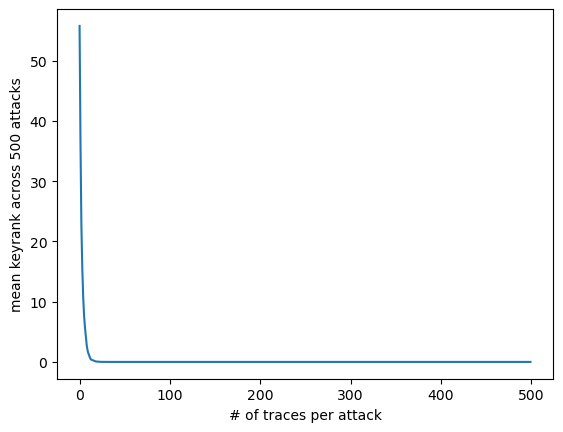

In [49]:
plt.plot(testing_keyrank)
plt.xlabel("# of traces per attack")
plt.ylabel("mean keyrank across 500 attacks")
plt.show()

## Gradient based saliency map

In [ ]:
def key_gradient_based_attribution(model : nn.Module, val_loader : DataLoader):
    grads = 0.

    sgd = optim.SGD(model.parameters())

    for traces, key in tqdm(val_loader, 'computing gradients'):

        traces : torch.Tensor = traces.to(device)

        # Set up gradient computation in computational graph
        traces.requires_grad = True
        traces.retain_grad()

        output = model(traces.squeeze())

        correct_idx = int(key)

        # Backward on magnitude sum of correct prediction
        output[correct_idx].sum().backward()

        grads += traces.grad\
            .squeeze()\
            .abs()\
            .mean(dim=0)
        
    return grads
        
def sbox_gradient_based_attribution(model : nn.Module, val_loader : DataLoader):
    grads = 0.

    # trace, plaintext, key
    for traces, _, key in tqdm(val_loader, 'computing gradients'):

        traces : torch.Tensor = traces.to(device)

        # Set up gradient computation in computational graph
        traces.requires_grad = True
        traces.retain_grad()

        output = model(traces.squeeze())

        correct_idx = int(key)

        # Backward on magnitude sum of correct prediction
        output[correct_idx].sum().backward()

        grads += traces.grad\
            .squeeze()\
            .abs()\
            .mean(dim=0)

    return grads

: 

: 

: 

In [ ]:
def plot_attribution_with_trace(attr_scores, trace_idx : int):
    fig = plt.figure(1,(8.0, 5.0))

    ax = fig.add_axes((1.0, 1.0, 1.0, 1.0))
    #ax.set_ylim(200.0, 700.0)

    score_mean = attr_scores.cpu().mean()
    score_std =  attr_scores.cpu().std()
    score_norm = (attr_scores.cpu() - score_mean) / score_std

    ax.plot(np.arange(1000), score_norm.abs() + 2.0, color='magenta', alpha=1.0)

    test_trace = val_test_traces[trace_idx][0][:1000]
    test_trace_mean = test_trace.mean()
    test_trace_std = test_trace.std()
    test_trace_norm = (test_trace - test_trace_mean) / test_trace_std

    ax2 = ax.twinx()
    ax.plot(np.arange(1000), test_trace_norm)

: 

: 

: 

In [ ]:
sbox_grads = sbox_gradient_based_attribution(sbox_model, sbox_val_loader)
key_grads = key_gradient_based_attribution(key_model, key_val_loader)

computing gradients: 100%|██████████| 500/500 [01:09<00:00,  7.22it/s]


: 

: 

: 

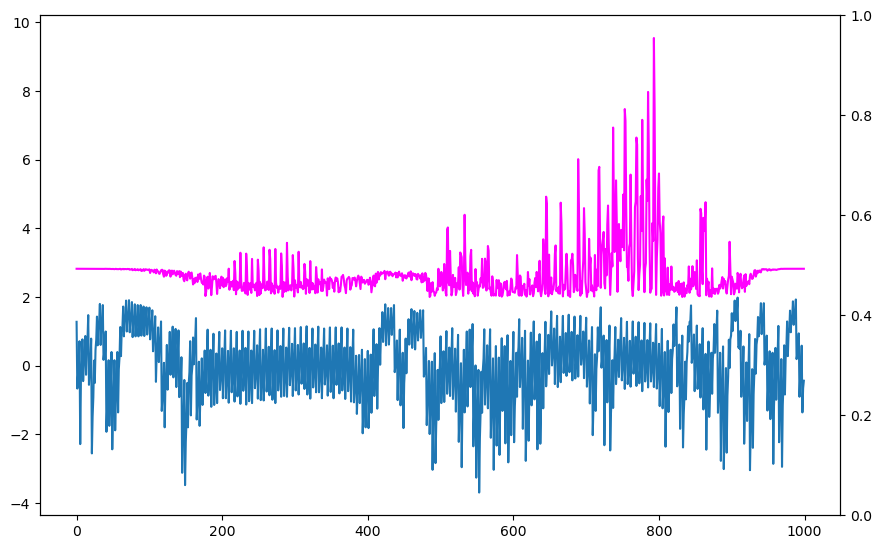

: 

: 

: 

In [ ]:
# What causes the jaggedness of the attribution scores?
# Is it an artifact of the computation?
# Trace is jagged == Attribution score is jagged?

plot_attribution_with_trace(sbox_grads, 141)

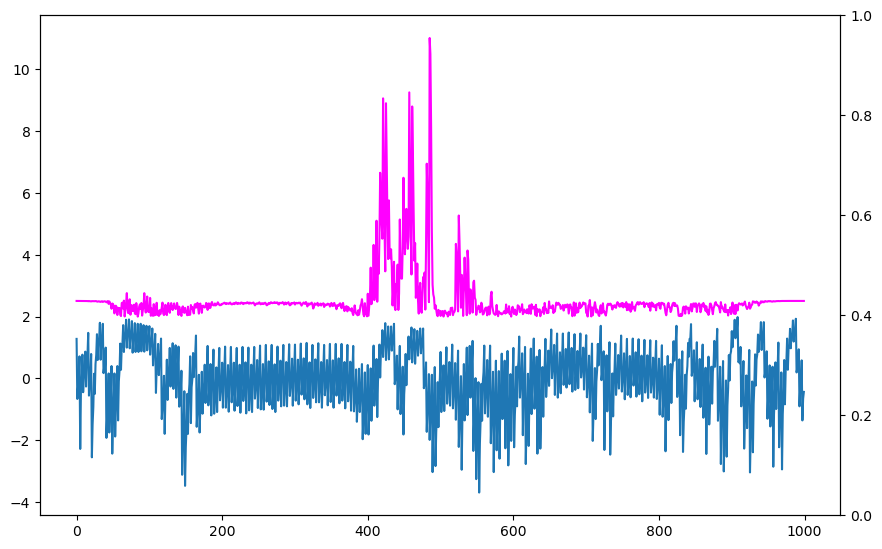

: 

: 

: 

In [ ]:
plot_attribution_with_trace(key_grads, 141)

## Occlusion based saliency map